# Impacts of activity cliff and stereochemistry in QSAR models
__Stereoisomerization__ refers to the phenomenon where molecules with the same molecular formula and connectivity (i.e., the same sequence of bonded atoms) differ in the spatial arrangement of their atoms, leading to the existence of stereoisomers. Stereoisomers are a type of isomer where the differences arise not from the sequence of bonds but from the orientation of atoms in three-dimensional space.

__Activity cliff__ (ACs) were generally defined as pairs of structurally similar active compounds with a large difference in potency. The existence of ACs directly defies the intuitive idea that chemical compounds with similar structures should have similar activities, often referred to as the molecular similarity principle. As such, ACs received strong attention in computational chemistry and drug design [Stumpfe et al. 2019](https://pubs.acs.org/doi/10.1021/acsomega.9b02221).

In this notebook, we explore the different types of stereoisomerization, how stereochemical information can be captured through molecular representations. We also examine the impact of stereoisomers that exhibit significant activity cliffs (ACs) in QSAR modeling.

In [1]:
# Note: Cell is tagged to not show up in the mkdocs build
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from copy import copy
import nglview as nv

import datamol as dm
from molfeat.trans.fp import FPVecTransformer

from utils import add_3d_coord

## Stereoisomerization
<!-- 
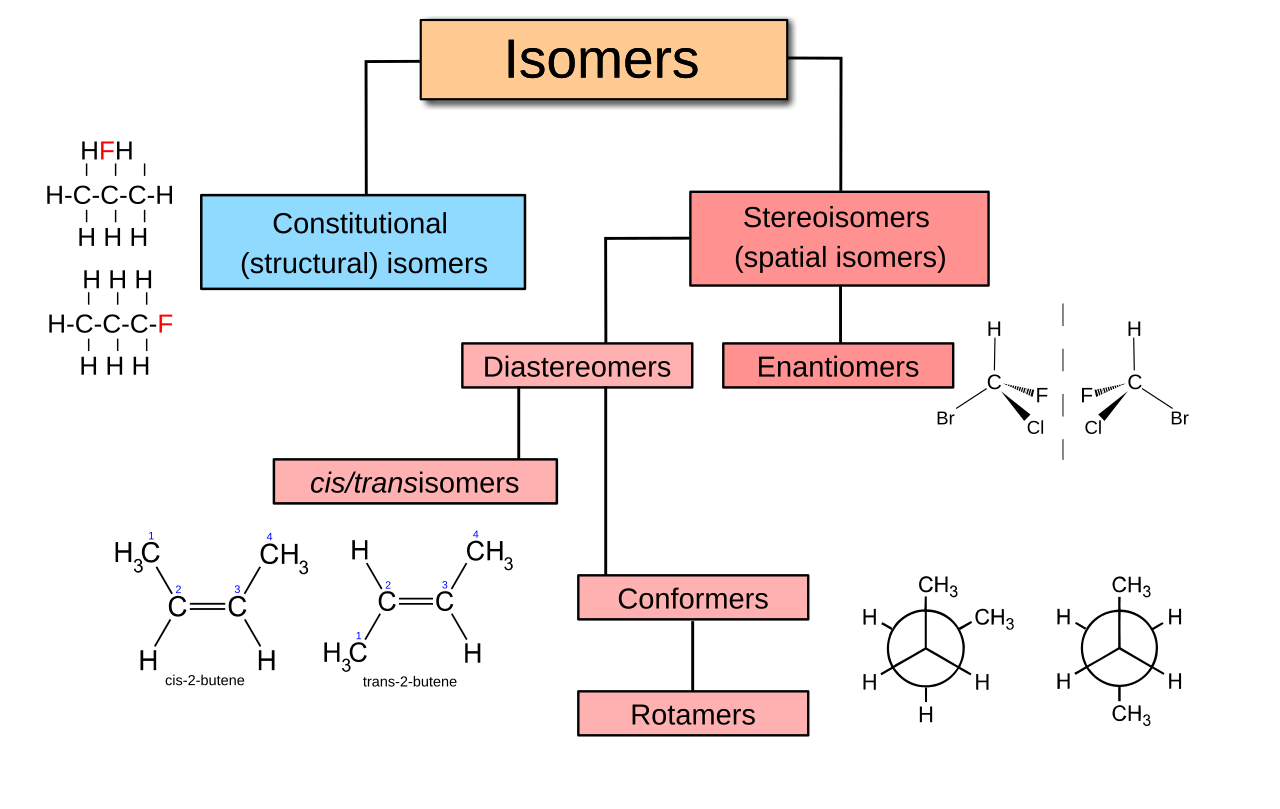
Image from https://en.wikipedia.org/wiki/Stereoisomerism -->

--> Ivan's figure

### Optical isomerism

Let's look at molecule Ibuprofen `CC(C)CC1=CC=C(C=C1)C(C)C(=O)O`.

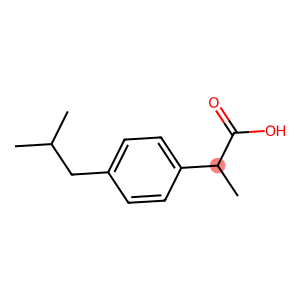

In [2]:
ibu = dm.to_mol("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O")
dm.to_image(mols=[ibu], highlight_atom=[10])

Actually the molecule is chiral with one stereocenter at `atom 10`.

This phenomenon is called `optical isomerism` which occurs when substances have the same molecular formula and structural formula, but one cannot be superimposed on the other.

Let's check all the stereoisomers of this molecule.

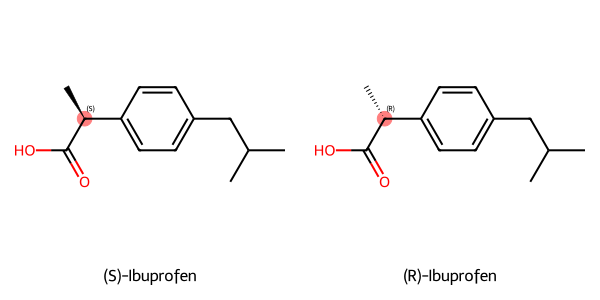

In [3]:
ibu_isomers = dm.isomers.enumerate_stereoisomers(ibu)

dm.to_image(
    ibu_isomers,
    highlight_atom=[[10], [10]],
    legends=["(S)-Ibuprofen", "(R)-Ibuprofen"],
    align=True,
)

In [33]:
# view (S)-Ibuprofen in 3D
view1 = nv.show_rdkit(ibu_isomers[0])
view1

NGLWidget()

In [34]:
# view (R)-Ibuprofen in 3D
view2 = nv.show_rdkit(ibu_isomers[1])
view2

NGLWidget()

Their string representations in SMILES are as below. The chirality can be specified in SMILES strings, such as `C@H` and `C@@H` for enantiomers.

In [6]:
[dm.to_smiles(isomer) for isomer in ibu_isomers]

['CC(C)Cc1ccc([C@H](C)C(=O)O)cc1', 'CC(C)Cc1ccc([C@@H](C)C(=O)O)cc1']

Similarily the stereochemistry can also be differenciated in Ichi string.

In [7]:
[dm.to_inchi(isomer) for isomer in ibu_isomers]

['InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)/t10-/m0/s1',
 'InChI=1S/C13H18O2/c1-9(2)8-11-4-6-12(7-5-11)10(3)13(14)15/h4-7,9-10H,8H2,1-3H3,(H,14,15)/t10-/m1/s1']

Molecules are often converted to `rdkit.mol` before being transformed other advanced features vectors. 
The isomers are seen as differernt `rdkit.mol` object. 

In [8]:
if not dm.same_mol(ibu_isomers[0], ibu_isomers[1]):
    print("The two molecules are not identical!")

The two molecules are not identical!


### E/Z isomerism

Now let's have a look at another type of stereoisomerism - `E/Z isomerism`. \
It only occurs if the groups bonded to each carbon atom in the`C=C` bond are different. \
See the example in below:

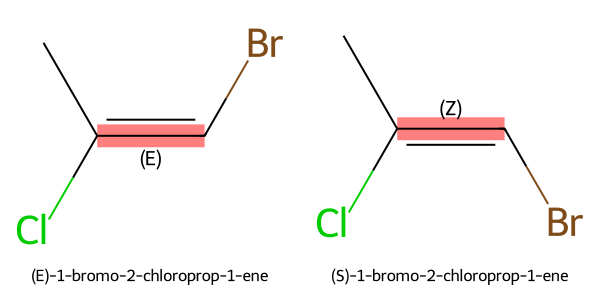

In [9]:
mol = dm.to_mol("CC(=CBr)Cl")
isomers = dm.isomers.enumerate_stereoisomers(mol)

dm.to_image(
    isomers,
    highlight_bond=[[1], [1]],
    legends=["(E)-1-bromo-2-chloroprop-1-ene", "(S)-1-bromo-2-chloroprop-1-ene"],
    align=True,
)

Similarily,  E/Z isomers can be specified by `/` and `\` in SMILES strings.


In [10]:
[dm.to_smiles(isomer) for isomer in isomers]

['C/C(Cl)=C\\Br', 'C/C(Cl)=C/Br']

In [11]:
if not dm.same_mol(isomers[0], isomers[1]):
    print("The two molecules are not identical!")

The two molecules are not identical!


In [12]:
assert dm.to_inchi(ibu_isomers[0]) != dm.to_inchi(ibu_isomers[1])

`Note:` In many cases, one molecule could contain multiple stereocenters and multiple types of stereochemisty information. 

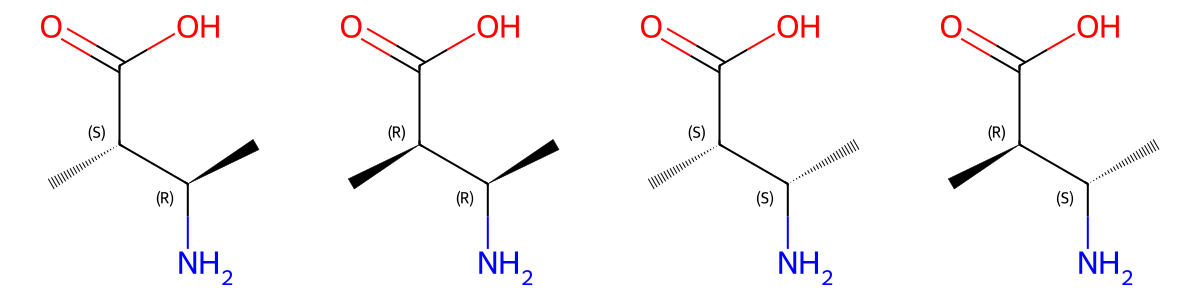

In [13]:
# multiple stereocenters in one molecule
mols_1 = dm.to_mol("CC(C(=O)O)C(N)C")
dm.to_image(dm.isomers.enumerate_stereoisomers(mols_1), align=True)

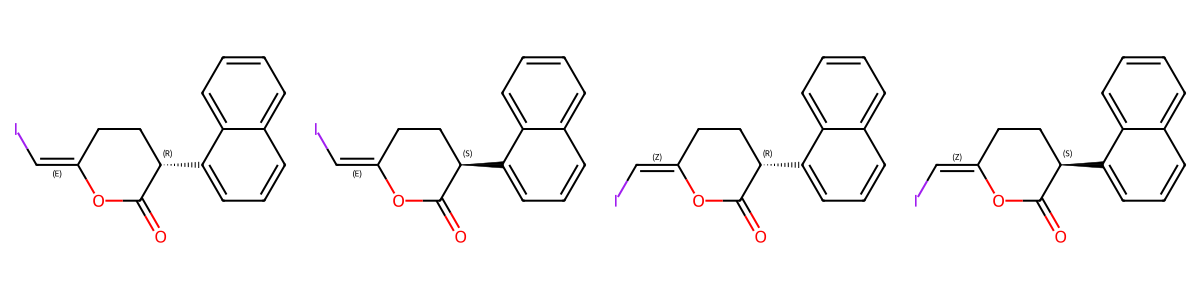

In [14]:
# Optical isomerism and E/Z isomerism in one molecule
mols_2 = dm.to_mol("O=C1OC(=CI)CCC1c1cccc2ccccc12")
dm.to_image(dm.isomers.enumerate_stereoisomers(mols_2), align=True)

### When is stereochemistry information important in QSAR and when is it not ?

For stereoselective targets, the 3D arrangement of atoms can significantly affect how they interact with biological targets. Different enantiomers or diastereomers can have vastly different pharmacological effects, binding affinities, and activity profiles.

**Example**: 
The β2-adrenergic receptor has a specific 3D shape that the (R)-albuterol fits into more precisely than the (S)-albuterol. The (R)-Albuterol provides more effective treatment with fewer side effects targeting β2-adrenergic receptors in comparison to the S-enantiomer. 

On the other hand, for non-stereoselective targets interacts similarly with all stereoisomers, then stereochemistry may not impact the activity, and including it in dataset may be unnecessary.

Similarily, the physicochemical properties of a molecules, such as solubility, logP, etc,  which are not significantly influenced by stereochemistry, therefore detailed stereochemical information may not be required. 


`Attention`: In the cases of  stereoselective targets, it's important to define all the stereoinformation of a molecule if possible. 
The undefined or partially defined molecule might cause the challenges in QSAR modeling. It’s important to minimize the number of undefined stereoisomers in the dataset.

It's worth mentionining that in early-stage drug discovery, where high-throughput screening (HTS) is used to identify hits from large libraries, the focus is often on broad activity trends rather than precise stereochemical interactions. As a result,stereochemistry may be ignored by testing on  racemics mixture, making it impossible to determine the exact stereochemistry of the molecules. Therefore, when using models trained on such data, it is important to specify the limitations of these models, particularly regarding their applicability to other molecule sets.

## Stereisomers with activity cliff and the impact on QSAR 

Stereoisomers might exhibit activity cliffs, where small changes in stereochemistry result in large differences in biological activity. Those stereoisomers with activity cliffs can pose challenges to QSAR modeling by creating sharp contrasts in biological activity that are not easily captured by standard models.

Accurate representation of stereochemistry and careful model design are crucial for addressing these challenges and improving the predictive accuracy and interpretability of QSAR models.

### Choice of molecular representations for stereoisomerism

Here we use featurizers(molecular transformers) from [molfeat](https://molfeat.datamol.io/) which is a hub of molecular featurizers. It supports a wide variety of out-of-the-box molecular featurizers from Fingerprints, pretrained-featurizers, deep embeddings (proteins+small mol), to molecular descriptors.

In [15]:
# generate conformers/3d coordinates
mol1_3d = dm.conformers.generate(ibu_isomers[0])
mol2_3d = dm.conformers.generate(ibu_isomers[1])
mol3_3d = dm.conformers.generate(isomers[0])
mol4_3d = dm.conformers.generate(isomers[1])

**Featurizer 1**: Let’s use the ECFP featurizer, which encodes the presence of specific substructures or features in a molecule. It is one of the most commonly used molecular representations in QSAR modeling.

In [16]:
transfomer_1 = FPVecTransformer(kind="ecfp:4", length=2042)
fp1 = transfomer_1(mol1_3d)
fp2 = transfomer_1(mol2_3d)
if np.array_equal(fp1, fp2):
    print(f"This featurizer '{transfomer_1.kind}' can't differenciate the two enantiomers!")

This featurizer 'ecfp:4' can't differenciate the two enantiomers!


In [17]:
fp3 = transfomer_1(mol3_3d)
fp4 = transfomer_1(mol4_3d)
if np.array_equal(fp3, fp4):
    print(f"This featurizer '{transfomer_1.kind}' can't differenciate the two diastereoisomers!")

This featurizer 'ecfp:4' can't differenciate the two diastereoisomers!


Now let’s explore more sophisticated featurizers that captures the 3D information of molecules.

**Featurizer 2**: 3D version of the CATS pharmacophores computed with the Pharm2D module in RDKit.

In [18]:
from molfeat.trans.base import MoleculeTransformer
from molfeat.calc.pharmacophore import Pharmacophore3D

# define transformer
transformer_2 = MoleculeTransformer(featurizer=Pharmacophore3D(factory="cats"), dtype=float)
feat1 = transformer_2(mol1_3d)
feat2 = transformer_2(mol2_3d)
if not np.array_equal(feat1, feat2):
    print(f"This featurizer '{transformer_2.featurizer.factory}' can differenciate the enantiomers!")

This featurizer 'cats' can differenciate the enantiomers!


In [19]:
feat3 = transformer_2(mol3_3d)
feat4 = transformer_2(mol4_3d)
if not np.array_equal(feat1, feat2):
    print(f"This featurizer '{transformer_2.featurizer.factory}' can differenciate the diastereoisomers!")

This featurizer 'cats' can differenciate the diastereoisomers!


Please find more deatails about featurizer [pharm3D-cats](https://molfeat.datamol.io/featurizers/pharm3D-cats) and explore other available featurizers on [molfeat](https://molfeat.datamol.io/) page.

###  QSAR modeling with stereoisomers exhibiting activity cliffs

In this section, we’ll take a closer look at how activity cliffs between stereoisomers can impact the predictive performance of QSAR modeling.

#### Example case: Dopamine receptor D2
The dopamine D2 receptor, like many G-protein-coupled receptors (GPCRs), exhibits stereoselectivity, meaning it binds more effectively to certain stereoisomers of ligands than to others. This stereoselectivity plays a crucial role in the pharmacological effects of drugs targeting the D2 receptor [Xiao et al. 2014](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315423/).

Here, our **goal** is to train predictive models that perform well on both molecules that exhibit activity cliffs and those that do not.

`Note`: The dataset used in this notebooks is heterogeneous extracted from CHEMBL for demonstration purpose. 

In [20]:
# Load data set of small molecule inhibitors of dopamine receptor D2
data = pd.read_csv("data/dopamine_d2_data.csv")

In [ ]:
mol_col = "MOL_smiles"  # molecule smiles strings
val_col = "CLS_pChEMBL Value"  # class label for binding affinity

mols = dm.utils.parallelized(
    fn=lambda mol: add_3d_coord(mol),
    inputs_list=data[mol_col],
    progress=True,
    n_jobs=10,
)
data["mol"] = mols

In [22]:
## You can also use `dm.conformers.generate` for 3d coordinates generation.
## Note: this function might take longer time
# mols = dm.utils.parallelized(
#     fn=lambda mol: dm.conformers.generate(dm.to_mol(mol)),
#     inputs_list=data[mol_col],
#     progress=True,
#     n_jobs=10,
# )
# data["mol"] = mols

In [23]:
# the dataset was pre-split to train/test based on the presence of activity cliffs
data_train = data.query("split == 'train'")
data_test = data.query("split == 'test'")

In [24]:
col_AC = "AC_CLS_pChEMBL Value"  # boolean: whether the molecule show activity cliff in the dataset
data.groupby("split")[col_AC].value_counts()

split  AC_CLS_pChEMBL Value
test   False                   1361
       True                     103
train  False                   5451
       True                     102
Name: count, dtype: int64

#### Training with simple RandomForest model

To evaluate the impact of including stereochemistry information on prediction performance, we will train two QSAR models using the same machine learning algorithm and parameters. 

One model will use the `ECFP:4` featurizer, which does not capture stereochemistry, while the other will use the `pharm3D-cats` featurizer, which includes 3D stereochemical information.

In [25]:
# Define the model with specified parameters

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    bootstrap=True,
    criterion="gini",
    verbose=True,
    n_jobs=-1,
)

**Model 1**: `RandomForestClassifier` + `ECFP:4`

In [26]:
# Transform with featurizer which can't differe stereoisomers
transformer_1 = FPVecTransformer(kind="ecfp:4", dtype=float)
X_train = transformer_1(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values

model_1 = copy(model)
# Fit the model
model_1.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

**Model 2**: `RandomForestClassifier` + `pharm3D-cats`

In [27]:
X_train = transformer_2(data_train["mol"].values)

# Define the labels
y_train = data_train[val_col].values
model_2 = copy(model)
# Fit the model
model_2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RandomForestClassifier(n_jobs=-1, verbose=True)

#### Compare the predictive performance on test set

In [28]:
results = {"overall": {}, "AC": {}}

#### Overall performance on entire test set

In [29]:
from utils import evaluate

results["overall"]["rf+ecfp"] = evaluate(data_test, transformer_1, model_1, mol_col="mol", val_col=val_col)

results["overall"]["rf+pharm3Dcats"] = evaluate(
    data_test, transformer_2, model_2, mol_col="mol", val_col=val_col
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [30]:
pd.DataFrame(results["overall"])

,rf+ecfp,rf+pharm3Dcats
precision,0.796510,0.744475
recall,0.788154,0.706368
f1-score,0.791550,0.712694
support,1464.000000,1464.000000


#### Performance on stereoisomers which show activity cliff

In [31]:
results["AC"]["rf+ecfp"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_1,
    model_1,
    mol_col="mol",
    val_col=val_col,
)
results["AC"]["rf+pharm3Dcats"] = evaluate(
    data_test.query("`AC_CLS_pChEMBL Value` == True"),
    transformer_2,
    model_2,
    mol_col="mol",
    val_col=val_col,
)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.0s finished


In [32]:
pd.DataFrame(results["AC"])

,rf+ecfp,rf+pharm3Dcats
precision,0.271780,0.420928
recall,0.272642,0.424151
f1-score,0.271570,0.419302
support,103.000000,103.000000


QSAR modeling for stereoselective targets and activity cliffs is always challenging.
The results above demonstrate that while the model trained with `pharm3D-cats` underperformed in overall prediction accuracy, it significantly outperformed when predicting the activity of stereoisomers with activity cliffs. This highlights the importance of using molecular representations that effectively capture stereochemistry.

When applying predictive models to a different set of molecules, it is crucial to carefully select the appropriate model for deployment. In this example, if we aim to make predictions on a lead series of molecules that contain key stereocenters essential for binding to the D2 target, the model `rf+pharm3Dcats` should be chosen. Conversely, for datasets consisting of non-chiral molecules, the `rf+ecfp` model would be sufficient.

## Final notes

Careful data curation and auditing are essential to determine whether bioactivity in a given dataset is selective to stereochemistry. `Auroris` simplifies and streamlines this process by providing the [StereoIsomerACDetection](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L61) module and the corresponding  [detect_streoisomer_activity_cliff](https://github.com/polaris-hub/auroris/blob/3b8792a7d5c7fefbf08a2c0b087f99dc3fa69088/auroris/curation/actions/_ac_stereoisomer.py#L15) function to easily assess this issue. 

For guidance on how to combine different Auroris modules for small molecule dataset curation, please checkout this [tutorial](https://polaris-hub.github.io/auroris/stable/tutorials/getting_started.html).

The end.